# Continual Task Finetuning with Transformer Encoder

This notebook mirrors `dynamic_task_finetuning_demo.ipynb` and swaps in the transformer-based foundation encoder before adding PI polymer tasks through dynamic fine-tuning.


## Data Overview

- **Descriptors**: `data/amorphous_polymer_FFDescriptor_20250730.parquet`
- **Non-PI properties**: `data/amorphous_polymer_non_PI_properties_20250730.parquet`
- **PI properties**: `data/amorphous_polymer_PI_properties_20250730.parquet`
- Target regression labels (normalized): density, Cp, Rg, linear_expansion

In [10]:
from pathlib import Path
import json
import math
import re
from typing import Any

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from loguru import logger as fm_logger

from foundation_model.data.datamodule import CompoundDataModule
from foundation_model.models.flexible_multi_task_model import FlexibleMultiTaskModel
from foundation_model.models.model_config import RegressionTaskConfig, TaskType, OptimizerConfig, TransformerEncoderConfig, EncoderType


In [4]:
DATA_DIR = Path("../data")
DESCRIPTOR_PATH = DATA_DIR / "amorphous_polymer_FFDescriptor_20250730.parquet"
NON_PI_PATH = DATA_DIR / "amorphous_polymer_non_PI_properties_20250730.parquet"
PI_PATH = DATA_DIR / "amorphous_polymer_PI_properties_20250730.parquet"
SCALER_PATH = DATA_DIR / "amorphous_polymer_properties_scaler_20250730.pkl.z"

use_normalized_targets = True  # use normalized target columns when loading data
keep_normalized_targets = False  # if True, keep plots/metrics in normalized space
QUIET_MODEL_LOGGING = True  # If True, reduce model logging output

def target_column(property_name: str) -> str:
    return f"{property_name}{' (normalized)' if use_normalized_targets else ''}"

TARGET_COLUMNS = {
    "density": target_column("density"),
    "Cp": target_column("Cp"),
    "Rg": target_column("Rg"),
    "linear_expansion": target_column("linear_expansion"),
}

# Transformer encoder configuration tuned for polymer descriptors
SHARED_BLOCK_DIMS = [190, 256]
TRANSFORMER_ENCODER_CONFIG = TransformerEncoderConfig(
    d_model=256,
    num_layers=4,
    nhead=8,
    dropout=0.1,
    use_cls_token=True,
    apply_layer_norm=True,
)
ENCODER_CONFIG = TRANSFORMER_ENCODER_CONFIG
LATENT_WIDTH = ENCODER_CONFIG.latent_dim
HEAD_HIDDEN = 64  # hidden width for regression heads
ARTIFACT_ROOT = Path("../artifacts/polymers_dynamic_tasks_transformer")
ARTIFACT_ROOT.mkdir(parents=True, exist_ok=True)

PRETRAIN_SAMPLE = 200_000  # subset for quick demonstration
PI_SAMPLE = None  # use full PI set by default

PROPERTY_SCALERS: dict[str, Any] = {}

if QUIET_MODEL_LOGGING:
    fm_logger.disable("foundation_model")
else:
    fm_logger.enable("foundation_model")

def base_property_name(task_name: str) -> str:
    """Map task names like "density (PI)" back to base property keys."""
    return task_name.split(" (", 1)[0]


In [5]:
descriptor_df = pd.read_parquet(DESCRIPTOR_PATH)
non_pi_df = pd.read_parquet(NON_PI_PATH)
pi_df = pd.read_parquet(PI_PATH)

if use_normalized_targets:
    if not SCALER_PATH.exists():
        raise FileNotFoundError(f"Missing scaler file: {SCALER_PATH}")
    PROPERTY_SCALERS = joblib.load(SCALER_PATH)
    missing_scalers = [name for name in TARGET_COLUMNS if name not in PROPERTY_SCALERS]
    if missing_scalers:
        raise KeyError(f"Scaler missing entries for: {missing_scalers}")
else:
    PROPERTY_SCALERS = {}

missing_pretrain = [column for column in TARGET_COLUMNS.values() if column not in non_pi_df.columns]
if missing_pretrain:
    raise KeyError(f"Non-PI table missing columns: {missing_pretrain}")

missing_pi = [column for column in TARGET_COLUMNS.values() if column not in pi_df.columns]
if missing_pi:
    raise KeyError(f"PI table missing columns: {missing_pi}")

common_non_pi = descriptor_df.index.intersection(non_pi_df.index)
pretrain_features = descriptor_df.loc[common_non_pi]
pretrain_targets = non_pi_df.loc[common_non_pi, list(TARGET_COLUMNS.values())]

if PRETRAIN_SAMPLE is not None and PRETRAIN_SAMPLE < len(pretrain_features):
    pretrain_features = pretrain_features.sample(n=PRETRAIN_SAMPLE, random_state=42)
    pretrain_targets = pretrain_targets.loc[pretrain_features.index]

common_pi = descriptor_df.index.intersection(pi_df.index)
pi_features = descriptor_df.loc[common_pi]
pi_targets = pi_df.loc[common_pi, list(TARGET_COLUMNS.values())]

if PI_SAMPLE is not None and PI_SAMPLE < len(pi_features):
    pi_features = pi_features.sample(n=PI_SAMPLE, random_state=13)
    pi_targets = pi_targets.loc[pi_features.index]

print(f"Pre-train feature tensor: {pretrain_features.shape}")
print(f"Pre-train targets: {pretrain_targets.shape}")
print(f"Fine-tune feature tensor: {pi_features.shape}")
print(f"Fine-tune targets: {pi_targets.shape}")


Pre-train feature tensor: (71725, 190)
Pre-train targets: (71725, 4)
Fine-tune feature tensor: (1083, 190)
Fine-tune targets: (1083, 4)


## Build Task Configurations

In [6]:
def build_regression_task(name: str, column: str) -> RegressionTaskConfig:
    return RegressionTaskConfig(
        name=name,
        data_column=column,
        dims=[LATENT_WIDTH, HEAD_HIDDEN, 1],
        norm=True,
        residual=False,
    )

pretrain_task_configs = [build_regression_task(name, col) for name, col in TARGET_COLUMNS.items()]
pi_task_configs = [build_regression_task(f"{name} (PI)", col) for name, col in TARGET_COLUMNS.items()]

print("Pretrain tasks:", [cfg.name for cfg in pretrain_task_configs])
print("PI tasks:", [cfg.name for cfg in pi_task_configs])


Pretrain tasks: ['density', 'Cp', 'Rg', 'linear_expansion']
PI tasks: ['density (PI)', 'Cp (PI)', 'Rg (PI)', 'linear_expansion (PI)']


In [7]:
def plot_test_predictions(
    model: FlexibleMultiTaskModel,
    datamodule: CompoundDataModule,
    stage_label: str,
    device: str | None = None,
    artifact_dir: Path | str | None = None,
) -> None:
    """Render predicted vs. actual scatter plots and persist evaluation artifacts."""
    if device is None:
        if torch.cuda.is_available():
            device = "cuda"
        elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
            device = "mps"
        else:
            device = "cpu"

    datamodule.setup(stage="test")
    test_loader = datamodule.test_dataloader()
    if test_loader is None:
        raise RuntimeError(f"{stage_label} datamodule does not define a test_dataloader().")

    artifact_base = Path(artifact_dir) if artifact_dir is not None else ARTIFACT_ROOT
    artifact_base.mkdir(parents=True, exist_ok=True)
    stage_slug = re.sub(r"[^a-z0-9]+", "_", stage_label.lower()).strip("_")
    if not stage_slug:
        stage_slug = "stage"
    stage_dir = artifact_base / stage_slug
    stage_dir.mkdir(parents=True, exist_ok=True)
    metrics_path = stage_dir / "metrics.json"
    predictions_path = stage_dir / "predictions.csv"

    original_device = next(model.parameters()).device
    was_training = model.training

    model = model.to(device)
    model.eval()

    aggregated: dict[str, dict[str, list[torch.Tensor]]] = {}
    csv_rows: list[dict[str, float | str | int]] = []

    def maybe_denormalize(task_name: str, preds_arr: np.ndarray, targets_arr: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        if not use_normalized_targets or keep_normalized_targets:
            return preds_arr, targets_arr
        scaler = PROPERTY_SCALERS.get(base_property_name(task_name))
        if scaler is None:
            return preds_arr, targets_arr
        preds_denorm = scaler.inverse_transform(preds_arr.reshape(-1, 1)).reshape(-1)
        targets_denorm = scaler.inverse_transform(targets_arr.reshape(-1, 1)).reshape(-1)
        return preds_denorm, targets_denorm

    with torch.no_grad():
        for batch in test_loader:
            x, y_dict, mask_dict, t_sequences = batch
            x = x.to(device)
            preds = model(x, t_sequences)

            for name, pred_tensor in preds.items():
                if name not in y_dict:
                    continue

                target_tensor = y_dict[name]
                mask_tensor = mask_dict.get(name)

                if isinstance(target_tensor, list):
                    target_flat = torch.cat([t.detach().cpu().reshape(-1) for t in target_tensor])
                else:
                    target_flat = target_tensor.detach().cpu().reshape(-1)

                pred_flat = pred_tensor.detach().cpu().reshape(-1)

                if mask_tensor is not None:
                    if isinstance(mask_tensor, list):
                        mask_flat = torch.cat([m.detach().cpu().reshape(-1) for m in mask_tensor])
                    else:
                        mask_flat = mask_tensor.detach().cpu().reshape(-1)
                    mask_flat = mask_flat.bool()
                    target_flat = target_flat[mask_flat]
                    pred_flat = pred_flat[mask_flat]

                if target_flat.numel() == 0:
                    continue

                entry = aggregated.setdefault(name, {"preds": [], "targets": []})
                entry["preds"].append(pred_flat)
                entry["targets"].append(target_flat)

    if not aggregated:
        print(f"No test predictions available for {stage_label}.")
        model.to(original_device)
        if was_training:
            model.train()
        return

    metrics: dict[str, dict[str, float | int | None | bool]] = {}
    items = sorted(aggregated.items())
    num_tasks = len(items)
    cols = 2 if num_tasks > 1 else 1
    rows = math.ceil(num_tasks / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.5, rows * 4.5))
    axes_list = axes.flatten().tolist() if hasattr(axes, "flatten") else [axes]

    for ax, (name, data) in zip(axes_list, items):
        preds = torch.cat(data["preds"]).numpy()
        targets = torch.cat(data["targets"]).numpy()
        preds, targets = maybe_denormalize(name, preds, targets)

        diff = preds - targets
        mae = float(np.mean(np.abs(diff)))
        mse = float(np.mean(diff ** 2))
        rmse = float(np.sqrt(mse))
        ss_tot = float(np.sum((targets - targets.mean()) ** 2))
        ss_res = float(np.sum(diff ** 2))
        r2 = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else None

        metrics[name] = {
            "samples": int(targets.size),
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "r2": r2,
            "normalized": keep_normalized_targets,
        }

        lo = float(min(preds.min(), targets.min()))
        hi = float(max(preds.max(), targets.max()))
        buffer = 0.05 * (hi - lo) if hi > lo else 0.1
        lo -= buffer
        hi += buffer

        ax.scatter(targets, preds, s=12, alpha=0.6, edgecolors="none")
        ax.plot([lo, hi], [lo, hi], "--", color="tab:red", linewidth=1)
        annotation = rf"MAE: {mae:.3f} $R^2$: {r2:.3f}" if r2 is not None else f"MAE: {mae:.3f}"
        ax.text(0.05, 0.95, annotation, transform=ax.transAxes, fontsize=10,
                verticalalignment="top", bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.6))
        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")
        ax.set_title(f"{stage_label}: {name}")
        ax.grid(alpha=0.2)
        ax.set_aspect("equal", adjustable="box")

        for sample_idx, (actual_val, pred_val) in enumerate(zip(targets, preds)):
            csv_rows.append(
                {
                    "stage": stage_label,
                    "task": name,
                    "sample_index": sample_idx,
                    "actual": float(actual_val),
                    "predicted": float(pred_val),
                }
            )

    for ax in axes_list[len(items):]:
        ax.axis("off")

    fig.tight_layout()
    plt.show()

    if csv_rows:
        pd.DataFrame(csv_rows).to_csv(predictions_path, index=False)
        print(f"Saved predictions to {predictions_path}")

    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=2)
    print(f"Saved metrics to {metrics_path}")

    model.to(original_device)
    if was_training:
        model.train()


## Stage 1 — Pre-train on non-PI polymers

In [8]:
pretrain_datamodule = CompoundDataModule(
    formula_desc_source=pretrain_features,
    attributes_source=pretrain_targets,
    task_configs=pretrain_task_configs,
    batch_size=256,
    num_workers=0,
    # val_split=0.1,
    # test_split=0.1,
)

pretrain_model = FlexibleMultiTaskModel(
    shared_block_dims=SHARED_BLOCK_DIMS,
    task_configs=pretrain_task_configs,
    encoder_config=ENCODER_CONFIG,
    enable_learnable_loss_balancer=True,
    # enable_learnable_loss_balancer=False,
    shared_block_optimizer=OptimizerConfig(lr=5e-4)
)

pretrain_checkpoint_dir = ARTIFACT_ROOT / "pretrain_checkpoints"
pretrain_checkpoint_dir.mkdir(parents=True, exist_ok=True)
pretrain_ckpt = ModelCheckpoint(
    dirpath=pretrain_checkpoint_dir,
    filename="pretrain-{epoch:02d}-{val_final_loss:.4f}",
    monitor="val_final_loss",
    mode="min",
    save_top_k=1,
)

pretrain_logger = CSVLogger(save_dir=ARTIFACT_ROOT / "logs", name="pretrain")
pretrain_tensorboard_logger = TensorBoardLogger(
    save_dir=ARTIFACT_ROOT / "logs",
    name="pretrain_tensorboard",
)

pretrain_early_stopping = EarlyStopping(
    monitor="val_final_loss",
    mode="min",
    patience=10,
)

pretrain_trainer = Trainer(
    max_epochs=1000,
    accelerator="auto",
    devices="auto",
    callbacks=[pretrain_ckpt, pretrain_early_stopping],
    logger=[pretrain_logger, pretrain_tensorboard_logger],
    # log_every_n_steps=10,
    # limit_train_batches=0.2,
    # limit_val_batches=0.5,
)

pretrain_trainer.fit(pretrain_model, datamodule=pretrain_datamodule)
print(f"Best checkpoint: {pretrain_ckpt.best_model_path}")


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type                 | Params | Mode 
---------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict        | 4      | train
1 | encoder             | FoundationEncoder    | 3.2 M  | train
2 | shared              | _TransformerBackbone | 3.2 M  | train
3 | deposit             | Sequential           | 65.8 K | train
4 | task_heads          | ModuleDict           | 66.6 K | train
5 | disabled_task_heads | ModuleDict           | 0      | train
---------------------------------------------------------------------
3.3 M     Trainable p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 112: 100%|██████████| 225/225 [01:08<00:00,  3.26it/s, v_num=0, train_final_loss_step=-0.844, val_final_loss=-1.79, train_final_loss_epoch=-2.08]     
Best checkpoint: /Users/liuchang/projects/foundation_model/artifacts/polymers_dynamic_tasks_transformer/pretrain_checkpoints/pretrain-epoch=102-val_final_loss=-1.9096.ckpt


### Pre-train test evaluation


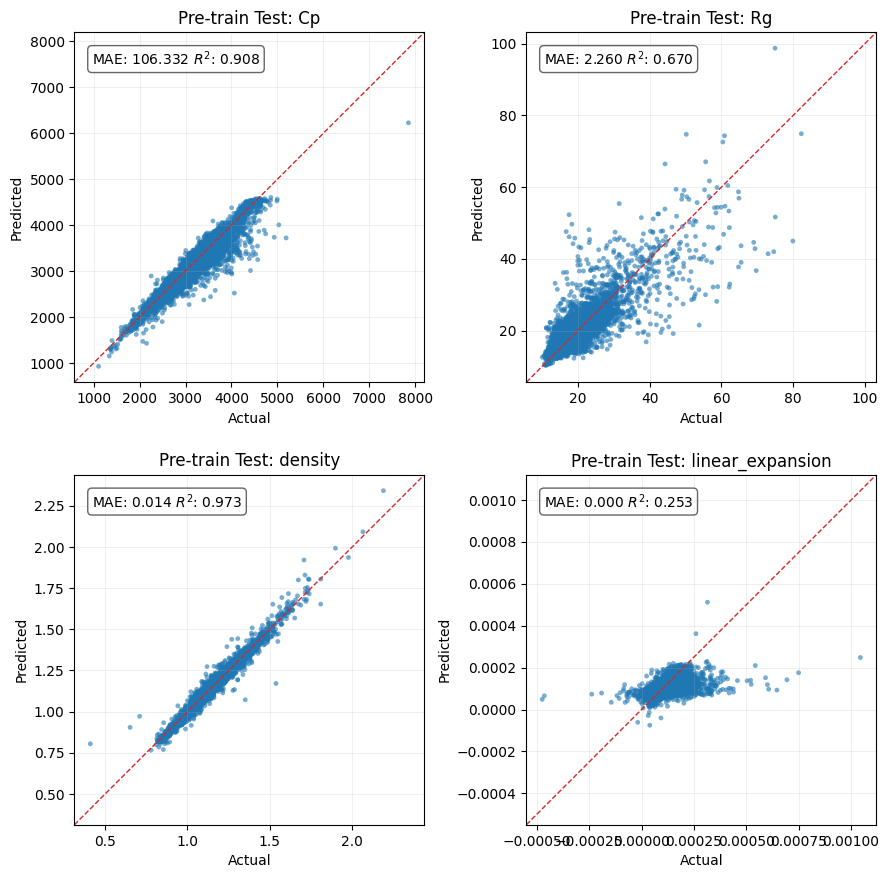

Saved predictions to ../artifacts/polymers_dynamic_tasks_transformer/pre_train_test/predictions.csv
Saved metrics to ../artifacts/polymers_dynamic_tasks_transformer/pre_train_test/metrics.json


In [11]:
torch.serialization.add_safe_globals([RegressionTaskConfig, TaskType, OptimizerConfig, TransformerEncoderConfig, EncoderType])

if pretrain_ckpt.best_model_path:
    pretrain_state = torch.load(pretrain_ckpt.best_model_path, map_location="cpu", weights_only=True)
    pretrain_state_dict = pretrain_state.get("state_dict", pretrain_state)
    pretrain_model.load_state_dict(pretrain_state_dict)
else:
    print("No best checkpoint found for pre-training; using current model weights.")

plot_test_predictions(pretrain_model, pretrain_datamodule, "Pre-train Test", artifact_dir=ARTIFACT_ROOT)


## Stage 2 — Fine-tune newly added PI tasks

In [12]:
torch.serialization.add_safe_globals([RegressionTaskConfig, TaskType, OptimizerConfig, TransformerEncoderConfig])

pi_datamodule = CompoundDataModule(
    formula_desc_source=pi_features,
    attributes_source=pi_targets,
    task_configs=pi_task_configs,
    batch_size=64,
    num_workers=0,
    # val_split=0.2,
    # test_split=0.0,
)

# finetune_model = FlexibleMultiTaskModel(
#     shared_block_dims=SHARED_BLOCK_DIMS,
#     task_configs=pretrain_task_configs,
#     enable_learnable_loss_balancer=True,
#     freeze_shared_encoder=True,
# )

best_ckpt_path = pretrain_ckpt.best_model_path
if not best_ckpt_path:
    raise RuntimeError("Pre-training did not produce a checkpoint. Check earlier cells for errors.")

# state = torch.load(best_ckpt_path, map_location="mps", weights_only=True)
# finetune_model.load_state_dict(state["state_dict"], strict=False)

finetune_model = FlexibleMultiTaskModel.load_from_checkpoint(
    checkpoint_path=best_ckpt_path,
    strict=False,
    freeze_shared_encoder=True,
)
finetune_model.remove_tasks(*TARGET_COLUMNS.keys())
finetune_model.add_task(*pi_task_configs)

print("Trainable task heads:", list(finetune_model.task_heads.keys()))


Trainable task heads: ['density (PI)', 'Cp (PI)', 'Rg (PI)', 'linear_expansion (PI)']


In [13]:
finetune_checkpoint_dir = ARTIFACT_ROOT / "finetune_checkpoints"
finetune_checkpoint_dir.mkdir(parents=True, exist_ok=True)
finetune_ckpt = ModelCheckpoint(
    dirpath=finetune_checkpoint_dir,
    filename="finetune-{epoch:02d}-{val_final_loss:.4f}",
    monitor="val_final_loss",
    mode="min",
    save_top_k=1,
)

finetune_logger = CSVLogger(save_dir=ARTIFACT_ROOT / "logs", name="finetune")
finetune_tensorboard_logger = TensorBoardLogger(
    save_dir=ARTIFACT_ROOT / "logs",
    name="finetune_tensorboard",
)

finetune_early_stopping = EarlyStopping(
    monitor="val_final_loss",
    mode="min",
    patience=10,
)

finetune_trainer = Trainer(
    max_epochs=200,
    accelerator="auto",
    devices="auto",
    callbacks=[finetune_ckpt, finetune_early_stopping],
    logger=[finetune_logger, finetune_tensorboard_logger],
    log_every_n_steps=5,
    limit_train_batches=1.0,
    limit_val_batches=1.0,
)

finetune_trainer.fit(finetune_model, datamodule=pi_datamodule)
print(f"Best fine-tuning checkpoint: {finetune_ckpt.best_model_path}")


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name                | Type                 | Params | Mode 
---------------------------------------------------------------------
0 | task_log_sigmas     | ParameterDict        | 4      | train
1 | encoder             | FoundationEncoder    | 3.2 M  | train
2 | shared              | _TransformerBackbone | 3.2 M  | train
3 | deposit             | Sequential           | 65.8 K | train
4 | task_heads          | ModuleDict           | 66.6 K | train
5 | disabled_task_heads | ModuleDict           | 0      | train
---------------------------------------------------------------------
66.6 K    Trainable params
3.2 M     Non-trainable params
3.3 M     Total params
13.171    Total estimated model params size (MB)
93    

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 199: 100%|██████████| 14/14 [00:00<00:00, 21.28it/s, v_num=0, train_final_loss_step=-0.43, val_final_loss=-0.512, train_final_loss_epoch=-0.589]    

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 14/14 [00:00<00:00, 21.09it/s, v_num=0, train_final_loss_step=-0.43, val_final_loss=-0.512, train_final_loss_epoch=-0.589]
Best fine-tuning checkpoint: /Users/liuchang/projects/foundation_model/artifacts/polymers_dynamic_tasks_transformer/finetune_checkpoints/finetune-epoch=198-val_final_loss=-0.5159.ckpt


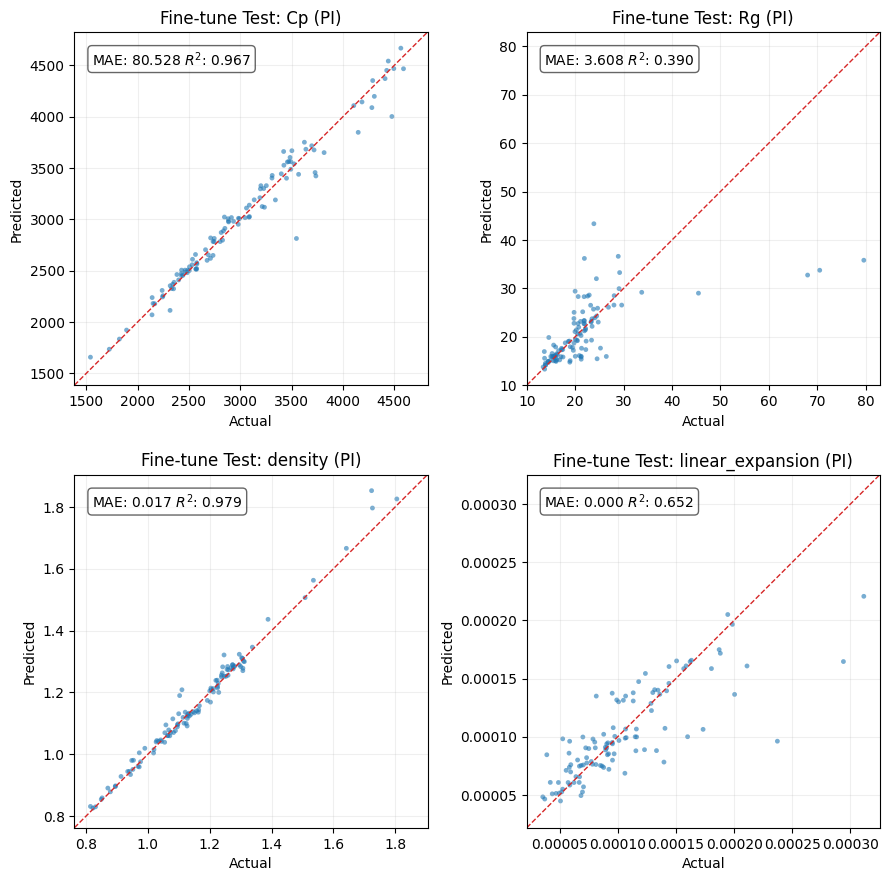

Saved predictions to ../artifacts/polymers_dynamic_tasks_transformer/fine_tune_test/predictions.csv
Saved metrics to ../artifacts/polymers_dynamic_tasks_transformer/fine_tune_test/metrics.json


In [14]:
if finetune_ckpt.best_model_path:
    finetune_state = torch.load(finetune_ckpt.best_model_path, map_location="cpu", weights_only=True)
    finetune_state_dict = finetune_state.get("state_dict", finetune_state)
    finetune_model.load_state_dict(finetune_state_dict)
else:
    print("No best checkpoint found for fine-tuning; using current model weights.")

plot_test_predictions(finetune_model, pi_datamodule, "Fine-tune Test", artifact_dir=ARTIFACT_ROOT)


## Inspect fine-tuned predictions

In [ ]:
pi_datamodule.setup(stage="test")
val_loader = pi_datamodule.test_dataloader()
example_batch = next(iter(val_loader))

with torch.no_grad():
    outputs = finetune_model(example_batch[0], example_batch[3])

for name, tensor in outputs.items():
    print(name, tensor[:5].squeeze().cpu().numpy())

2025-10-30 06:38:25.891 | INFO     | datamodule:setup:444 - --- Setting up DataModule for stage: test ---
2025-10-30 06:38:25.891 | INFO     | datamodule:setup:454 - Total samples available before splitting (from attributes_df index): 1083
2025-10-30 06:38:25.891 | INFO     | datamodule:setup:484 - Data split strategy: Performing random train/val/test splits based on full_idx (derived from attributes_df).
2025-10-30 06:38:25.891 | INFO     | datamodule:setup:487 - Test split ratio: 0.1, Validation split ratio (of non-test): 0.1
2025-10-30 06:38:25.892 | INFO     | datamodule:setup:499 - Split full data (1083) into train_val (974) and test (109) using seed 24.
2025-10-30 06:38:25.892 | INFO     | datamodule:setup:525 - Split train_val (974) into train (865) and val (109) using seed 42, effective_val_split 0.111.
2025-10-30 06:38:25.893 | INFO     | datamodule:setup:548 - Final dataset sizes after splitting: Train=865, Validation=109, Test=109
2025-10-30 06:38:25.893 | INFO     | datamod

density (PI) [ 0.43712002 -0.25057754 -0.96186584  0.2385511  -0.8497974 ]
Cp (PI) [-0.28870818  0.6167137   1.2780886  -0.65525216  0.4287603 ]
Rg (PI) [-0.00595162  0.5554697  -0.11048783  0.57406926 -1.4589186 ]
linear_expansion (PI) [-0.20664649 -0.12641191  1.447959   -0.65430903  0.30042687]
